# Customer Segmentation Analysis
*Jiazhou Pang (Mar 2024)*

---
This Notebook analyzes an e-commerce dataset made available on the UCI Machine Learning Repository


#1. Importing Data


---

Import dataset from Kaggle and load all the modules needed. To access to the dataset on kaggle, I uploaded my kaggle account information as kaggle.json to the local runtime.

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download carrie1/ecommerce-data
!pip install git+https://github.com/rwalk/gsdmm.git
!pip install webcolors==1.5

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data
License(s): unknown
ecommerce-data.zip: Skipping, found more recently modified local copy (use --force to force download)
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-f1iutr37
  Running command git clone --filter=blob:none --quiet https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-f1iutr37
  Resolved https://github.com/rwalk/gsdmm.git to commit 4ad1b6b6976743681ee4976b4573463d359214ee
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotnine import *
import webcolors
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import re
from zipfile import ZipFile
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score as shs
from scipy.spatial.distance import cdist
from gsdmm import MovieGroupProcess

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
file = "ecommerce-data.zip"

with ZipFile(file, 'r') as zip:
    zip.printdir()
    zip.extractall()

File Name                                             Modified             Size
data.csv                                       2019-09-20 22:35:12     45580638


#2. Data Preparation


---


Basic information of the dataset:



In [4]:
df_initial = pd.read_csv('data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'], format='%m/%d/%Y %H:%M')
df_initial.shape

(541909, 8)

The Dataset has ***541909*** entries and ***8*** columns.

The descriptions of the columns are as follow:

* **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

* **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

* **Description**: Product (item) name. Nominal.

* **Quantity**: The quantities of each product (item) per transaction. Numeric.

* **InvoiceDate**: Invoice Date and time. Numeric, the day and time when each transaction was generated.

* **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.

* **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

* **Country**: Country name. Nominal, the name of the country where each customer resides.

Now I will take a closer look at the data.

In [5]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [6]:
df_initial.describe()

,Quantity,InvoiceDate,UnitPrice
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


The minimum quantity and the minimum UnitPrice are negative. To be investigated later.

In [7]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


The dataset contains null values under the Description and CustomerID columns. CustomerID is essential to my customer segmentation analysis. Therefore, I had to remove entries with missing CustomerIDs as they are unusable for my project.

In [8]:
null_df = df_initial[df_initial['CustomerID'].isnull()] # entries with null CustomerID

df_count = len(df_initial)
df_initial = df_initial.dropna(subset=['CustomerID'])
new_count = len(df_initial)
null_count = df_count - new_count

df_initial.info()

print()
print("Number of entries: {}\t Number of null entries dropped: {} \nEntries left: {}".format(df_count, null_count, new_count))

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB

Number of entries: 541909	 Number of null entries dropped: 135080 
Entries left: 406829


After removing the entries with no Cutomer IDs, the dataframe is now free of null entries.

Now, we investigate on the data entries with null values to investigate whether there is a pattern in entries with null values.

In [9]:
print("Non-null entries:")
print(df_initial['Country'].value_counts(normalize=True).head())

print("Null entries:")
print(null_df['Country'].value_counts(normalize=True).head())

Non-null entries:
Country
United Kingdom    0.889509
Germany           0.023339
France            0.020871
EIRE              0.018398
Spain             0.006226
Name: proportion, dtype: float64
Null entries:
Country
United Kingdom    0.989044
EIRE              0.005264
Hong Kong         0.002132
Unspecified       0.001495
Switzerland       0.000925
Name: proportion, dtype: float64


Here, I observed that 98.9% of the missing CusstomerIDs came from customers based of the UK. This is greater than the percentage of UK-based invoices in the cleaned dataframe.

In [10]:
df_count = len(df_initial)
df = df_initial.drop_duplicates()
new_count = len(df_initial)
dup_count = df_count - new_count

df.info()

print()
print("Number of entries: {}\t Number of duplicate entries dropped: {} \nEntries left: {}".format(df_count, dup_count, new_count))

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  object        
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.6+ MB

Number of entries: 406829	 Number of duplicate entries dropped: 0 
Entries left: 406829


In [11]:
df['CustomerID'].nunique()

4372

In [12]:
df['StockCode'].nunique()

3684

There are 4372 unique customers and 3684 unique products in the dataset.

#3. Exploratory Data Analysis


---


After null values are removed, I will now delve deeper into each columns.

## 3.1 Data Cleaning

Previously, I noticed that there are negative Quantity and UnitPrice entries in the dataset. Here I investigated those entries.

In [13]:
df.describe()

,Quantity,InvoiceDate,UnitPrice
count,401604.000000,401604,401604.000000
mean,12.183273,2011-07-10 12:08:23.848567552,3.474064
min,-80995.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-06 15:02:00,1.250000
50%,5.000000,2011-07-29 15:40:00,1.950000
75%,12.000000,2011-10-20 11:58:30,3.750000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,250.283037,NaN,69.764035


Now the UnitPrice is non-negative after removing rows containing null values. However, the Quantity column still contains negative values. The view below shows entries with the 5 least Quantity values.

In [14]:
df.sort_values(by=['Quantity']).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838,United Kingdom
160145,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2011-04-18 13:08:00,2.10,15749,United Kingdom
160144,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2011-04-18 13:08:00,1.85,15749,United Kingdom


Investigate entries with invoice no. that starts with "C"

In [15]:
mask = df['InvoiceNo'].str.startswith('C')
c_df = df[mask]
c_df.describe()

,Quantity,InvoiceDate,UnitPrice
count,8872.000000,8872,8872.000000
mean,-30.774910,2011-06-27 09:06:05.024797184,18.899512
min,-80995.000000,2010-12-01 09:41:00,0.010000
25%,-6.000000,2011-03-23 11:23:45,1.450000
50%,-2.000000,2011-07-11 13:51:00,2.950000
75%,-1.000000,2011-10-06 20:36:00,4.950000
max,-1.000000,2011-12-09 11:58:00,38970.000000
std,1172.249902,NaN,445.190864


In [16]:
c_df["StockCode"].value_counts()

StockCode
22423     180
M         175
POST       97
22960      86
D          77
         ... 
22977       1
22195       1
85024C      1
85025C      1
23843       1
Name: count, Length: 1920, dtype: int64

* Transactions with InvoiceNo starting with a "C" have negative quantities.
* Some of them are canceled orders. However, a fraction of those transactions are discounts, postage, or other miscellaneous fees.


An example of what canceled orders are like:

In [17]:
df[(df['CustomerID'].str.contains("17548"))].head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548,United Kingdom
165024,550755,22585,PACK OF 6 BIRDY GIFT TAGS,24,2011-04-20 12:01:00,1.25,17548,United Kingdom
165025,550755,22082,RIBBON REEL STRIPES DESIGN,10,2011-04-20 12:01:00,1.65,17548,United Kingdom
165026,550755,22081,RIBBON REEL FLORA + FAUNA,10,2011-04-20 12:01:00,1.65,17548,United Kingdom


For every cancelled order, I will find whether there is a matching order placed. If not, the cancelled order entries will be deleted. In addition, I will check if there are duplicating order cancels.

The code below is a modified version of codes produced by: https://www.kaggle.com/fabiendaniel

This block of code takes about 6 minutes to run.

In [18]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtful_entry = []

for index, col in  c_df.iterrows():
    if col['Description'] == 'Discount': continue

    mask = (df['CustomerID'] == col['CustomerID'])
    temp = df[mask]

    df_test = temp[(temp['InvoiceDate'] < col['InvoiceDate']) &
                         (temp['StockCode']  == col['StockCode']) &
                         (temp['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0):
        doubtful_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1):
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In [19]:
len(doubtful_entry)

1226

In [20]:
len(entry_to_remove)

7521

In [21]:
df_cleaned['CustomerID'].nunique()

4372

In [22]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtful_entry, axis = 0, inplace = True)
df_cleaned.to_pickle("./df_cleaned.pkl")

* In total, 8747 entries were removed
* 4339 unique customers left
* The cleaned dataframe was pickled for faster access

##3.2 Basket analysis
I will now conduct basket analysis.
* First, I calculated the amount of money spent on each product after taking in consideration of canceled orders.
* Next, I aggregated the spending based on CustomerID and InvoiceNo.
* The resulting dataframe basket_price contains the value of every individual transactions.

\\
Then, I plotted a histogram showing the distribution of basket values.

In [23]:
df_cleaned = pd.read_pickle("./df_cleaned.pkl")
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

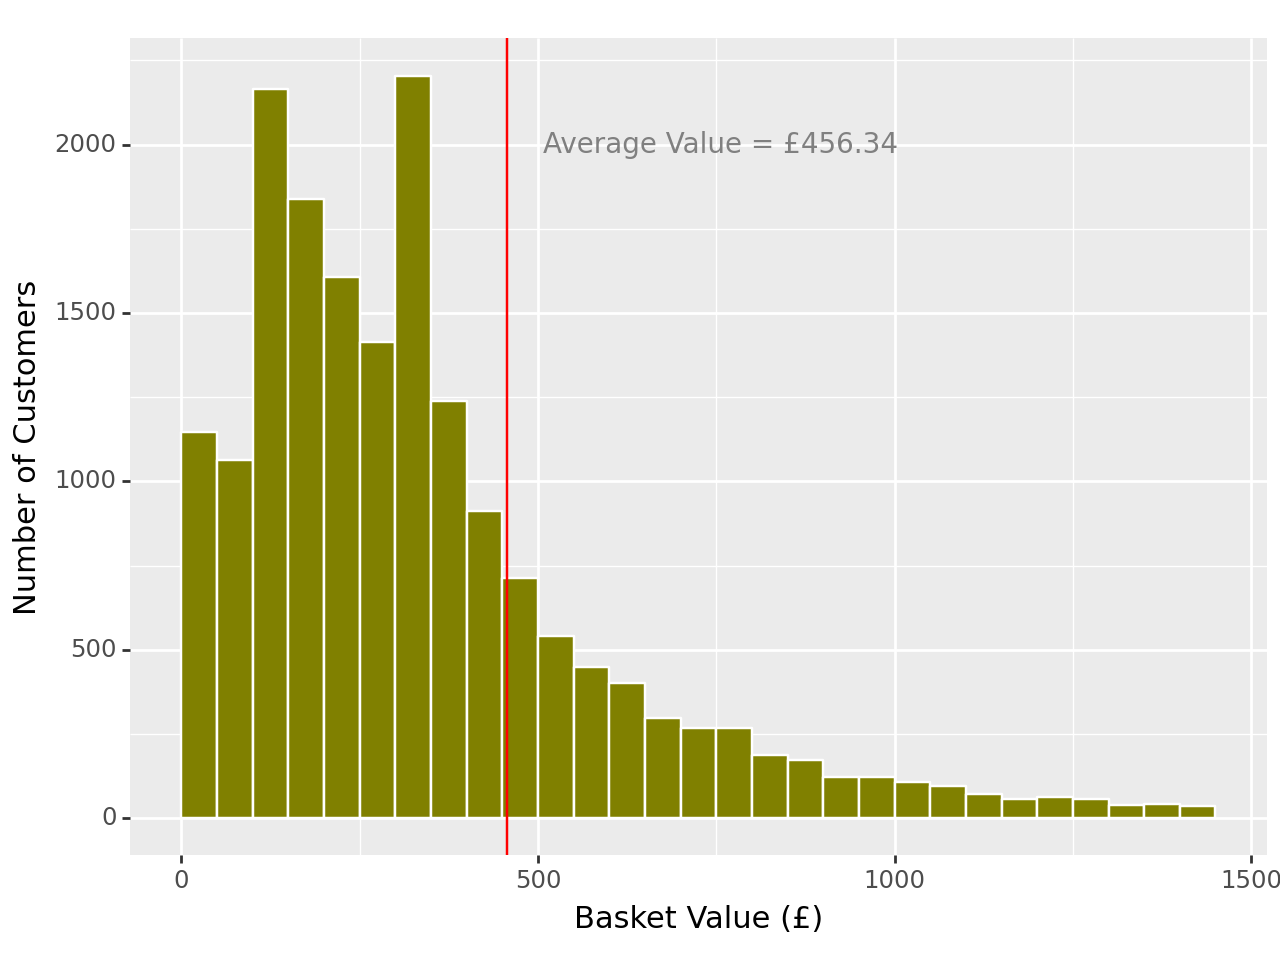

<Figure Size: (640 x 480)>

In [24]:
basket_price = df_cleaned.groupby(['CustomerID', 'InvoiceNo'])['TotalPrice'].sum()
basket_price = pd.DataFrame(basket_price[(basket_price > 0)]) # ignore orders where every product is canceled

basket_mean = basket_price['TotalPrice'].mean()

(
    ggplot(basket_price, aes(x='TotalPrice')) +
    geom_histogram(breaks=range(0,1500,50), fill="olive", color='white') +
    geom_vline(xintercept=basket_mean, color='red') +
    annotate("text", x=basket_mean+300, y=2000, label="Average Value = £{}".format(round(basket_mean,2)), size=10, color='gray') +
    xlab('Basket Value (£)') + ylab('Number of Customers')
    )

Here I calculated the average time for a customer to make another purchase. Only customers who made more than one purchase were considered.

In [25]:
customers_df = df_cleaned.groupby(['CustomerID', 'InvoiceNo']).agg({'InvoiceDate': 'min'})

customer_list = list(df_cleaned['CustomerID'].unique())
TDelta = []

for customer in customer_list:
  temp = customers_df.loc[customer,:].diff()

  if len(temp) > 1:
    mean_time = temp.mean().dt.days
    TDelta.append(int(mean_time.iloc[0]))

print("Avg time between purchases: {} days".format(sum(TDelta)/len(TDelta)))

Avg time between purchases: 71.86476993326309 days


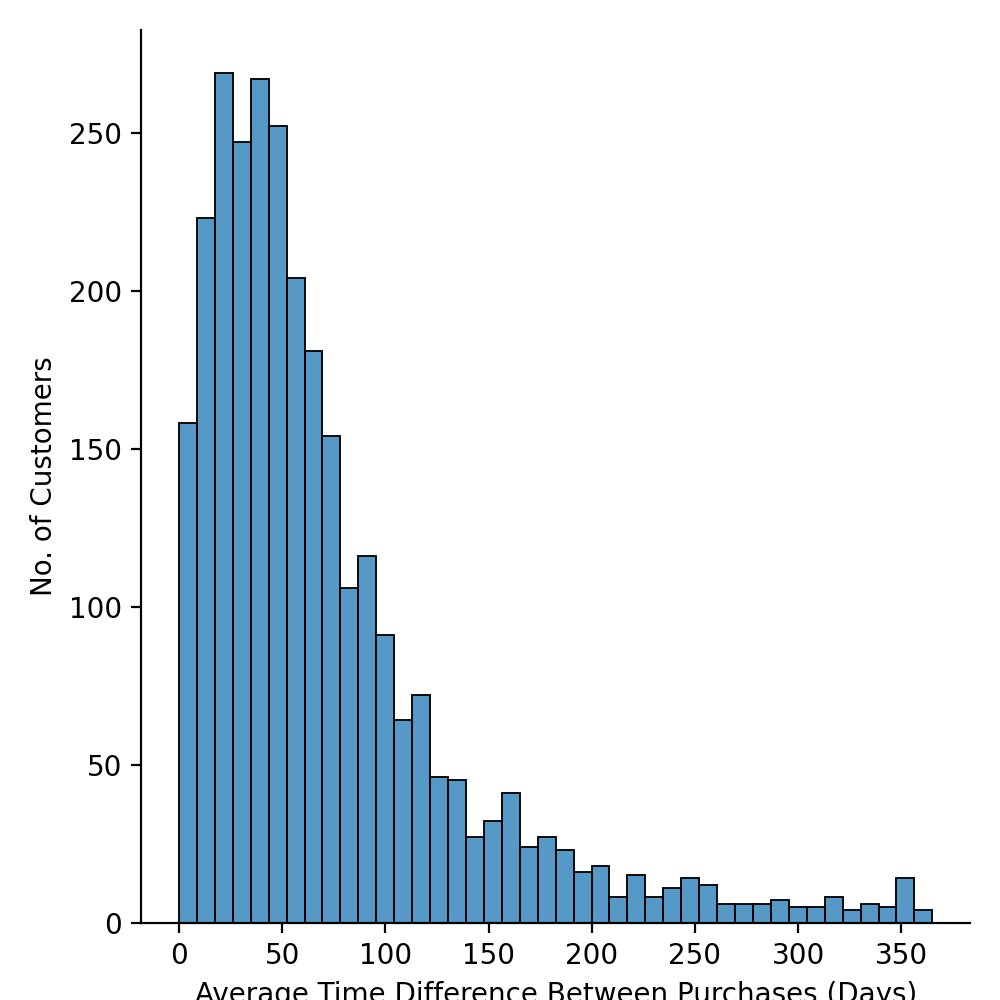

In [26]:
g = sns.displot(TDelta)
g.set_axis_labels('Average Time Difference Between Purchases (Days)', 'No. of Customers')

##3.3 Calculating the churn rate

The formula for churn rate is as follows:
Churn rate = (Lost Customers / Total Customers at Start of Chosen time Period)

To calculate churn rate, I have to first establish a criteria for "lost customers". From the previous section, I have discovered customers take on average take 72 days to place their next order. Hence, here I define customers who have not placed any orders after Sep 01 2011 (100 days before the last date) as lost.

In [27]:
def churn_rate(df, end_date):
  '''
  The function takes a dataframe with InvoiceDate and CustomerID columns,
  it returns the percentage of customers that did not make any purchases after
  the specified end date.
  '''

  mask = (df['InvoiceDate'] >= end_date)
  temp = df[mask]
  total = len(df['CustomerID'].value_counts())
  not_churned = len(temp['CustomerID'].value_counts())
  churn = (total - not_churned) / total
  return churn

In [28]:
end_date = pd.Timestamp('2011-09-01')

df_uk = df_cleaned[(df_cleaned['Country'].str.contains('United Kingdom'))]
print("Number of UK-based customers = \t\t{}".format(len(df_uk)))
print("Churn rate for UK-based customers = \t{}".format(churn_rate(df_uk, end_date)))

df_others = df_cleaned[(~df_cleaned['Country'].str.contains('United Kingdom'))]
print()
print("Number of non-UK-based customers = \t{}".format(len(df_others)))
print("Churn rate for non-UK-based customers = {}".format(churn_rate(df_others, end_date)))

Number of UK-based customers = 		349347
Churn rate for UK-based customers = 	0.3142055598061719

Number of non-UK-based customers = 	43510
Churn rate for non-UK-based customers = 0.3157894736842105


In [29]:
# create a dataframe containing countries and their respective customer counts and churn rates
country_df = pd.DataFrame(df_cleaned['Country'].unique()).rename({0:'Country'}, axis=1)
country_df['ChurnRate'] = 0
country_df['CustomerCount'] = 0

for i, row in country_df.iterrows():
  temp = df_cleaned[(df_cleaned['Country']==row['Country'])]
  churn = churn_rate(temp, end_date)
  country_df.loc[i, 'ChurnRate'] = churn
  country_df.loc[i, 'CustomerCount'] = temp['CustomerID'].nunique()

country_df.head()

,Country,ChurnRate,CustomerCount
0,United Kingdom,0.314206,3921
1,France,0.275862,87
2,Australia,0.222222,9
3,Netherlands,0.333333,9
4,Germany,0.234043,94


This is an interactive choropleth showing the churn rate for each country. Hovering the cursor above any country would display the number of customers in that country.

In [30]:
fig = px.choropleth(country_df, locations="Country",
                    locationmode = 'country names',
                    color="ChurnRate",
                    hover_name="CustomerCount",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

#4. Text Mining


---



## 4.1 Text preprocessing

To fully utilize all the information the dataset encapsulates, I performed text mining on the product description column. A successful product clustering should help me better segment the customers.

First, I preprocessed the product Descriptions.

In [31]:
products_df = pd.DataFrame(df_cleaned['Description'].unique()).rename(columns = {0:'Description'}).sort_values(by='Description').reset_index(drop=True)
products_df.head()

,Description
0,4 PURPLE FLOCK DINNER CANDLES
1,50'S CHRISTMAS GIFT BAG LARGE
2,DOLLY GIRL BEAKER
3,I LOVE LONDON MINI BACKPACK
4,I LOVE LONDON MINI RUCKSACK


In the next block of code, I removed words describing colors, punctuations, and numbers. Then, I tokenized the words by using PorterStemmer and word_tokenize.

In [32]:
colors = list(webcolors.CSS3_NAMES_TO_HEX)
pat = r'\b(?:{})\b'.format('|'.join(colors).upper())

products_df['TokenizedDesc'] = products_df['Description'].str.replace(pat, '')
products_df['TokenizedDesc'] = products_df['TokenizedDesc'].str.replace('[{}]'.format(string.punctuation), '')

def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)

    for word in token_words:
      if word.isdigit():
        token_words.remove(word)

    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

products_df['TokenizedDesc'] = products_df['TokenizedDesc'].apply(lambda text: stemSentence(text))
products_df.head()

,Description,TokenizedDesc
0,4 PURPLE FLOCK DINNER CANDLES,purpl flock dinner candl
1,50'S CHRISTMAS GIFT BAG LARGE,'s christma gift bag larg
2,DOLLY GIRL BEAKER,dolli girl beaker
3,I LOVE LONDON MINI BACKPACK,i love london mini backpack
4,I LOVE LONDON MINI RUCKSACK,i love london mini rucksack


## 4.2 Text Clustering

The product descriptions are short. Hence, methods such as TFiDF or Word2Vec may not work well. Hence, I started with the most simplistic bag-of-words model as a benchmark. Then, I tried using Kmeans and DBSCAN to test out the cluster quality.  

In [33]:
vectorizer_cv = CountVectorizer(analyzer='word')
X = vectorizer_cv.fit_transform(products_df['TokenizedDesc'])

In [34]:
kmeans = KMeans(n_clusters=8, n_init='auto')
kmeans.fit(X)
y = kmeans.predict(X)
print(Counter(y))

Counter({0: 2332, 2: 441, 5: 226, 4: 208, 3: 197, 6: 188, 1: 145, 7: 141})


In [35]:
print('The Silhouette score for the kmeans clusters:')
print(shs(X, y))

The Silhouette score for the kmeans clusters:
0.036167615973614224


In [36]:
dbscan = DBSCAN(eps=0.5)
dbscan.fit(X)
y = dbscan.fit_predict(X)
Counter(y)

Counter({-1: 3824, 0: 10, 1: 24, 2: 10, 3: 10})

In [37]:
print('The Silhouette score for the kmeans clusters:')
print(shs(X, y))

The Silhouette score for the kmeans clusters:
-0.009832380136050946


A MovieGroupProcess is a conceptual model introduced by Yin and Wang 2014 to describe their Gibbs sampling algorithm for a Dirichlet Mixture Model for the clustering short text documents. I found this model to work very well in the context of this project.

In [38]:
mgp = MovieGroupProcess(K=10, alpha=0.1, beta=0.1, n_iters=30)
Desc = products_df['TokenizedDesc'].tolist()
vocab = set(x for doc in Desc for x in doc)
n_terms = len(vocab)
y = mgp.fit(Desc, vocab_size=n_terms)

In stage 0: transferred 3454 clusters with 10 clusters populated
In stage 1: transferred 3226 clusters with 10 clusters populated
In stage 2: transferred 2902 clusters with 10 clusters populated
In stage 3: transferred 2522 clusters with 10 clusters populated
In stage 4: transferred 2262 clusters with 10 clusters populated
In stage 5: transferred 2110 clusters with 10 clusters populated
In stage 6: transferred 2080 clusters with 10 clusters populated
In stage 7: transferred 2083 clusters with 10 clusters populated
In stage 8: transferred 2054 clusters with 10 clusters populated
In stage 9: transferred 1973 clusters with 10 clusters populated
In stage 10: transferred 1911 clusters with 10 clusters populated
In stage 11: transferred 1965 clusters with 10 clusters populated
In stage 12: transferred 2010 clusters with 10 clusters populated
In stage 13: transferred 2020 clusters with 10 clusters populated
In stage 14: transferred 1986 clusters with 10 clusters populated
In stage 15: transfe

In [39]:
products_df['cluster'] = y
Counter(products_df['cluster'])

Counter({4: 778,
         0: 251,
         3: 1129,
         9: 570,
         1: 405,
         2: 162,
         6: 362,
         8: 115,
         5: 82,
         7: 24})

In [40]:
products_df[(products_df['cluster'] == 0)].head()

,Description,TokenizedDesc,cluster
1,50'S CHRISTMAS GIFT BAG LARGE,'s christma gift bag larg,0
15,12 EGG HOUSE PAINTED WOOD,egg hous paint wood,0
27,12 PINK ROSE PEG PLACE SETTINGS,pink rose peg place set,0
50,3 RAFFIA RIBBONS 50'S CHRISTMAS,raffia ribbon 's christma,0
91,5 STRAND GLASS NECKLACE AMBER,strand glass necklac amber,0


Now, I will map the corresponding cluster numbers to df_cleaned.

In [41]:
product_mapping = dict()
for i, row in products_df.iterrows():
  key = row['Description']
  value = row['cluster']
  product_mapping[key] = value

df_cleaned['ProductCluster'] = df_cleaned.loc[:, 'Description'].map(product_mapping)

In [42]:
df_cleaned[(df_cleaned['QuantityCanceled']>0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,ProductCluster
65,536374,21258,VICTORIAN SEWING BOX LARGE,32,2010-12-01 09:09:00,10.95,15100,United Kingdom,12,219.00,3
96,536378,21212,PACK OF 72 RETROSPOT CAKE CASES,120,2010-12-01 09:37:00,0.42,14688,United Kingdom,2,49.56,4
98,536378,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,2010-12-01 09:37:00,0.55,14688,United Kingdom,1,12.65,4
99,536378,84991,60 TEATIME FAIRY CAKE CASES,24,2010-12-01 09:37:00,0.55,14688,United Kingdom,27,-1.65,3
139,536381,22719,GUMBALL MONOCHROME COAT RACK,36,2010-12-01 09:41:00,1.06,15311,United Kingdom,3,34.98,3


#5. Customer Segmentation


---


Customers can be segmented based on:
  1. Purchase History
  2. Country
  3. Customer persona

## 5.1 Feature Engineering

In [43]:
# aggregate the total amount of money a customer spent on each product cluster
for i in range(10):
  col = 'Cluster{}'.format(i)
  temp = df_cleaned[df_cleaned['ProductCluster'] == i]
  df_cleaned.loc[:, col] = temp['TotalPrice']
  df_cleaned[col].fillna(0, inplace = True)

In [44]:
df_cleaned['IsUK'] = (df_cleaned['Country'] == 'United Kingdom').astype(int)

First, I aggregated the cleaned dataframe on CustomerID and InvoiceNo to obtain information on each shopping basket. The dataframe is then aggregated again on CustomerID.

In [45]:
basket_df = df_cleaned.groupby(['CustomerID', 'InvoiceNo']).agg({'TotalPrice': 'sum',
                                                       'Cluster0': 'sum',
                                                       'Cluster1': 'sum',
                                                       'Cluster2': 'sum',
                                                       'Cluster3': 'sum',
                                                       'Cluster4': 'sum',
                                                       'Cluster5': 'sum',
                                                       'Cluster6': 'sum',
                                                       'Cluster7': 'sum',
                                                       'Cluster8': 'sum',
                                                       'Cluster9': 'sum',
                                                       'QuantityCanceled': 'sum',
                                                       'InvoiceDate': 'min',
                                                       'IsUK': 'mean'})

In [46]:
basket_df['IfCanceled'] = False
basket_df['IfCanceled'] = (basket_df['QuantityCanceled'] > 0)
basket_df['IfCanceled'] = basket_df['IfCanceled'].astype(int)

basket_df.head()

TotalPrice  Cluster0  Cluster1  Cluster2  Cluster3  \
CustomerID InvoiceNo                                                       
12346      541431           0.00       0.0      0.00       0.0      0.00   
12347      537626         711.79      17.4     78.20      84.0     75.20   
           542237         475.39       0.0     42.50      32.4    130.75   
           549222         636.25       0.0     35.00      19.8    421.85   
           556201         382.52       0.0     23.36       0.0    181.16   

                      Cluster4  Cluster5  Cluster6  Cluster7  Cluster8  \
CustomerID InvoiceNo                                                     
12346      541431          0.0      0.00       0.0       0.0       0.0   
12347      537626        187.5     85.65      22.5       0.0       0.0   
           542237        137.4     35.40      13.2       0.0      17.7   
           549222         67.8     10.20      17.7       0.0      16.2   
           556201         85.2     53.10      39.7       0.0       0.0   

                      Cluster9  QuantityCanceled         InvoiceDate  IsUK  \
CustomerID InvoiceNo                                                         
12346      541431         0.00             74215 2011-01-18 10:01:00   1.0   
12347      537626       161.34                 0 2010-12-07 14:57:00   0.0   
           542237        66.04                 0 2011-01-26 14:30:00   0.0   
           549222        47.70                 0 2011-04-07 10:43:00   0.0   
           556201         0.00                 0 2011-06-09 13:01:00   0.0   

                      IfCanceled  
CustomerID InvoiceNo              
12346      541431              1  
12347      537626              0  
           542237              0  
           549222              0  
           556201              0

The dataframe below describes each customer.

In [47]:
per_customer_df = basket_df.groupby('CustomerID').agg({'TotalPrice': ['count','min','max','mean','sum'],
                                                       'Cluster0': 'sum',
                                                       'Cluster1': 'sum',
                                                       'Cluster2': 'sum',
                                                       'Cluster3': 'sum',
                                                       'Cluster4': 'sum',
                                                       'Cluster5': 'sum',
                                                       'Cluster6': 'sum',
                                                       'Cluster7': 'sum',
                                                       'Cluster8': 'sum',
                                                       'Cluster9': 'sum',
                                                       'QuantityCanceled': 'sum',
                                                       'InvoiceDate': ['min', 'max'],
                                                       'IfCanceled': 'sum',
                                                       'IsUK': 'mean'})

end_date = pd.Timestamp('2011-12-11')
per_customer_df.columns = [' '.join(col).strip() for col in per_customer_df.columns.values] # flatten the muiltiindexed column headers
per_customer_df['FirstPurchase'] = (end_date - per_customer_df['InvoiceDate min']).dt.days # days since first purchase
per_customer_df['LastPurchase'] = (end_date - per_customer_df['InvoiceDate max']).dt.days # days since last purchase
per_customer_df['CancelRate'] = per_customer_df['IfCanceled sum']/per_customer_df['TotalPrice count']

per_customer_df = per_customer_df.drop(['InvoiceDate min', 'InvoiceDate max'], axis=1)
per_customer_df.head()

,TotalPrice count,TotalPrice min,TotalPrice max,TotalPrice mean,TotalPrice sum,Cluster0 sum,Cluster1 sum,Cluster2 sum,Cluster3 sum,Cluster4 sum,...,Cluster6 sum,Cluster7 sum,Cluster8 sum,Cluster9 sum,QuantityCanceled sum,IfCanceled sum,IsUK mean,FirstPurchase,LastPurchase,CancelRate
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,1,0.00,0.00,0.000000,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.00,74215,1,1.0,326,326,1.0
12347,7,224.82,1294.32,615.714286,4310.00,27.60,334.64,210.6,1692.03,913.80,...,154.70,0.0,33.90,499.18,0,0,0.0,368,3,0.0
12348,4,227.44,892.80,449.310000,1797.24,270.88,69.60,0.0,517.20,353.00,...,441.36,0.0,0.00,104.40,0,0,0.0,359,76,0.0
12349,1,1757.55,1757.55,1757.550000,1757.55,83.45,267.53,47.3,483.81,187.61,...,461.34,0.0,57.65,161.06,0,0,0.0,19,19,0.0
12350,1,334.40,334.40,334.400000,334.40,17.40,0.00,0.0,115.20,83.10,...,58.70,0.0,0.00,60.00,0,0,0.0,311,311,0.0


In [48]:
to_drop = ['TotalPrice min', 'TotalPrice mean','Cluster1 sum', 'Cluster2 sum', 'IfCanceled sum', 'QuantityCanceled sum', 'IsUK mean']
to_drop = ['TotalPrice min', 'TotalPrice mean', 'QuantityCanceled sum']
per_customer_df = per_customer_df.drop(to_drop, axis=1)
per_customer_df.describe()

,TotalPrice count,TotalPrice max,TotalPrice sum,Cluster0 sum,Cluster1 sum,Cluster2 sum,Cluster3 sum,Cluster4 sum,Cluster5 sum,Cluster6 sum,Cluster7 sum,Cluster8 sum,Cluster9 sum,IfCanceled sum,IsUK mean,FirstPurchase,LastPurchase,CancelRate
count,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000
mean,4.294077,577.275820,1932.267383,135.796421,216.637202,116.388334,563.856679,348.981526,24.678018,230.330486,0.094082,31.374685,264.129949,0.738880,0.903664,223.784052,93.003457,0.143009
std,7.816810,1135.696708,8376.984048,710.240084,1030.359617,644.749064,2531.168071,1497.144180,226.012960,1209.790674,3.083120,164.739836,1403.835378,2.231277,0.295085,117.885063,100.003611,0.262558
min,1.000000,0.000000,0.000000,-7.540000,0.000000,0.000000,-1987.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1.000000,216.795000,300.390000,0.950000,16.420000,0.000000,76.505000,35.130000,0.000000,21.055000,0.000000,0.000000,25.500000,0.000000,1.000000,113.000000,18.000000,0.000000
50%,2.000000,361.220000,653.750000,30.040000,58.800000,20.000000,187.450000,103.020000,0.000000,73.200000,0.000000,0.000000,79.200000,0.000000,1.000000,249.000000,51.000000,0.000000
75%,5.000000,610.185000,1624.035000,98.090000,165.700000,76.870000,467.790000,283.285000,10.630000,197.875000,0.000000,19.500000,208.775000,1.000000,1.000000,327.000000,142.500000,0.200000
max,211.000000,30757.000000,279558.620000,22201.000000,41947.970000,23790.000000,88405.580000,57103.210000,12565.600000,56090.330000,157.500000,5147.400000,63344.150000,69.000000,1.000000,374.000000,374.000000,1.000000


To assign equal importance to each feature, I applied a log transformation each feature in the dataset.

In [49]:
X = per_customer_df.copy(deep=True)
# translate columns so that the min of the column is positive
for i in range(10):
  col = 'Cluster{} sum'.format(i)
  a = 1 - X[col].min()
  X[col] = X[col] + a

X['IfCanceled sum'] = per_customer_df['IfCanceled sum']
X['FirstPurchase'] = per_customer_df['FirstPurchase']
X['LastPurchase'] = per_customer_df['LastPurchase']
X = np.log1p(X)

X['IsUK mean'] = per_customer_df['IsUK mean']
X['CancelRate'] = per_customer_df['CancelRate']

X.describe()

,TotalPrice count,TotalPrice max,TotalPrice sum,Cluster0 sum,Cluster1 sum,Cluster2 sum,Cluster3 sum,Cluster4 sum,Cluster5 sum,Cluster6 sum,Cluster7 sum,Cluster8 sum,Cluster9 sum,IfCanceled sum,IsUK mean,FirstPurchase,LastPurchase,CancelRate
count,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000
mean,1.346927,5.903688,6.548988,3.788040,3.870634,2.913587,7.772068,4.499864,1.638165,4.087823,0.698334,1.928688,4.176418,0.332941,0.903664,5.157997,3.856198,0.143009
std,0.684804,0.909604,1.296713,1.314005,1.822655,1.909953,0.294538,1.748330,1.405855,1.768826,0.125675,1.523447,1.769754,0.546120,0.295085,0.875503,1.307187,0.262558
min,0.693147,0.000000,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.693147,0.693147,0.000000
25%,0.693147,5.383554,5.708405,2.350422,2.913436,0.693147,7.633546,3.614425,0.693147,3.137881,0.693147,0.693147,3.314186,0.000000,1.000000,4.736198,2.944439,0.000000
50%,1.098612,5.892252,6.484253,3.678324,4.107590,3.091042,7.685845,4.654151,0.693147,4.320151,0.693147,0.693147,4.396915,0.000000,1.000000,5.521461,3.951244,0.000000
75%,1.791759,6.415400,7.393285,4.678699,5.122176,4.367801,7.806961,5.653487,2.536074,5.297692,0.693147,3.068053,5.350791,0.693147,1.000000,5.793014,4.966329,0.200000
max,5.356586,10.333905,12.540971,10.008322,10.644233,10.077105,11.411949,10.952651,9.438877,10.934754,5.072044,8.546635,11.056369,4.248495,1.000000,5.926926,5.926926,1.000000


In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4339 entries, 12346 to 18287
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TotalPrice count  4339 non-null   float64
 1   TotalPrice max    4339 non-null   float64
 2   TotalPrice sum    4339 non-null   float64
 3   Cluster0 sum      4339 non-null   float64
 4   Cluster1 sum      4339 non-null   float64
 5   Cluster2 sum      4339 non-null   float64
 6   Cluster3 sum      4339 non-null   float64
 7   Cluster4 sum      4339 non-null   float64
 8   Cluster5 sum      4339 non-null   float64
 9   Cluster6 sum      4339 non-null   float64
 10  Cluster7 sum      4339 non-null   float64
 11  Cluster8 sum      4339 non-null   float64
 12  Cluster9 sum      4339 non-null   float64
 13  IfCanceled sum    4339 non-null   float64
 14  IsUK mean         4339 non-null   float64
 15  FirstPurchase     4339 non-null   float64
 16  LastPurchase      4339 non-null   float64


## 5.2 KMeans
First I used the elbow method on inertia and distortion to determine K. In both instances, the rate of decrease becomes linear after K=3.
However, from the scatter plot generated using UMAP at a later section, 4 distinct clusters can be observed. Therefore, K=4 was chosen.

In [51]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init='auto').fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

Text(0.5, 1.0, 'The Elbow Method using Inertia')

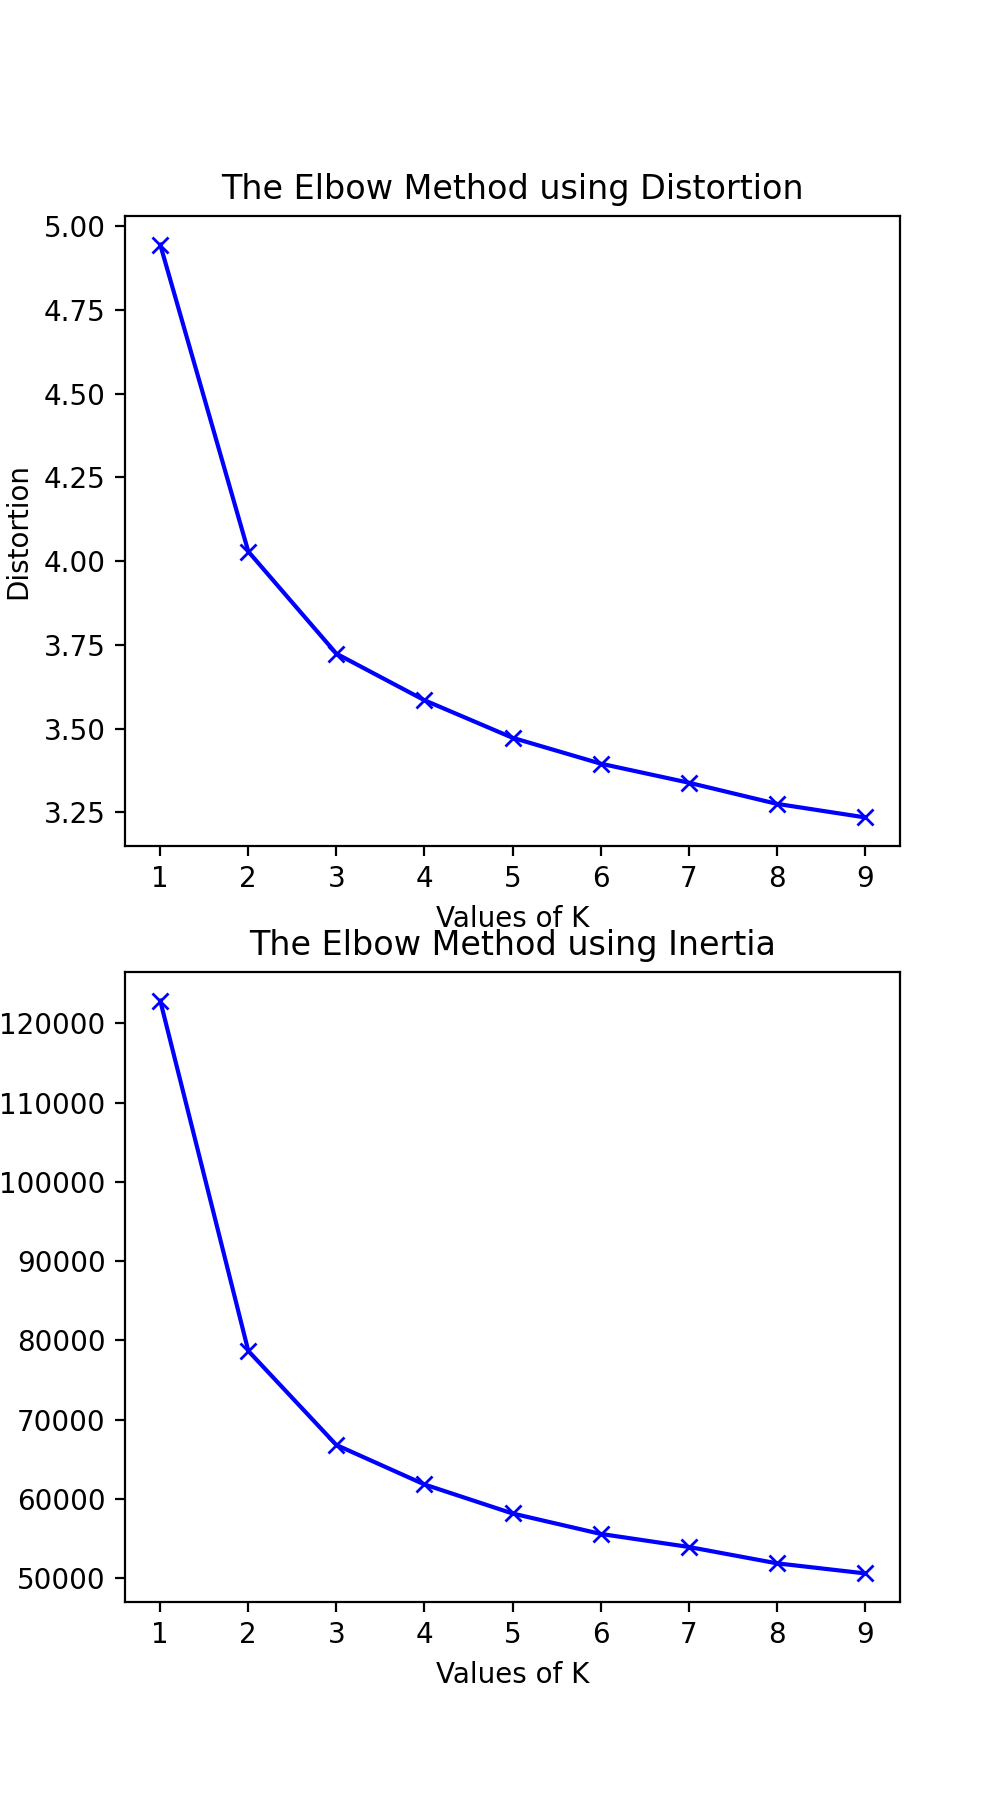

In [52]:
fig, ax = plt.subplots(2,1, figsize=(5, 9))
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('Values of K')
ax[0].set_ylabel('Distortion')
ax[0].set_title('The Elbow Method using Distortion')
ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('Values of K')
ax[1].set_ylabel('Inertia')
ax[1].set_title('The Elbow Method using Inertia')

In [53]:
kmeans = KMeans(n_clusters=4, n_init='auto')
kmeans.fit(X)
clusters = kmeans.predict(X)
Counter(clusters)

Counter({3: 911, 2: 560, 1: 1305, 0: 1563})

In [54]:
print('Silhouette score: {}'.format(shs(X, clusters)))

Silhouette score: 0.14816653492741766


## 5.3 HDBSCAN

Find the hyperparameters that maximizes the Density Based Clustering Validation (DBCV) obtained from HDBSCAN. However, the end result is two large clusters with numerous noise points. Therefore, the clusters obtained from KMeans were used for future parts of this project.

In [55]:
!pip install hdbscan
from hdbscan import HDBSCAN

In [56]:
min_cluster_space = np.arange(10, 15, 1)
min_samples_space = np.arange(4, 13, 1)
min_cluster_opt = 0.5
samples_opt = 5
DBSV_high = 0

for c in min_cluster_space:
  for samples in min_samples_space:
      clusterer = HDBSCAN(min_samples=samples,
                    min_cluster_size=c,
                    algorithm='best',
                    gen_min_span_tree=True)

      clusterer.fit(X)
      DBCV = clusterer.relative_validity_
      if DBCV >= DBSV_high:
        DBSV_high = DBCV
        min_cluster_opt = c
        samples_opt = samples

print(samples_opt)
print(min_cluster_opt)

8
10


In [57]:
clusterer = HDBSCAN(min_samples=samples_opt,
                    min_cluster_size=min_cluster_opt,
                    algorithm='best',
                    gen_min_span_tree=True)

clusterer.fit(X)
clusterer.relative_validity_

0.0021469112668858594

In [58]:
clusters_hdbscan = clusterer.labels_
Counter(clusters_hdbscan)

Counter({0: 10, -1: 1049, 2: 3256, 1: 24})

## 5.4 Visualization


Map the cluster numbers to the cleaned dataframe

In [59]:
per_customer_df['Pred'] = clusters

customer_mapping = dict()
for i, row in per_customer_df.iterrows():
  key = i
  value = row['Pred']
  product_mapping[key] = value

df_cleaned['CustomerSegment'] = df_cleaned.loc[:, 'CustomerID'].map(product_mapping)

In [60]:
!pip install umap-learn
!pip install umap-learn[plot]

import umap
import umap.plot

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning:

Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba

/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning:

Failed to dlopen libcuda.so.1

/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning:

Function "cuInit" not found

/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning:

The keyword argument 'no

Plot the data points and their cluster label on a 2-d plane using UMAP

In [61]:
y = clusters + 1 #cluser number starts at 1
manifold = umap.UMAP().fit(X, y)
X_reduced = manifold.transform(X)

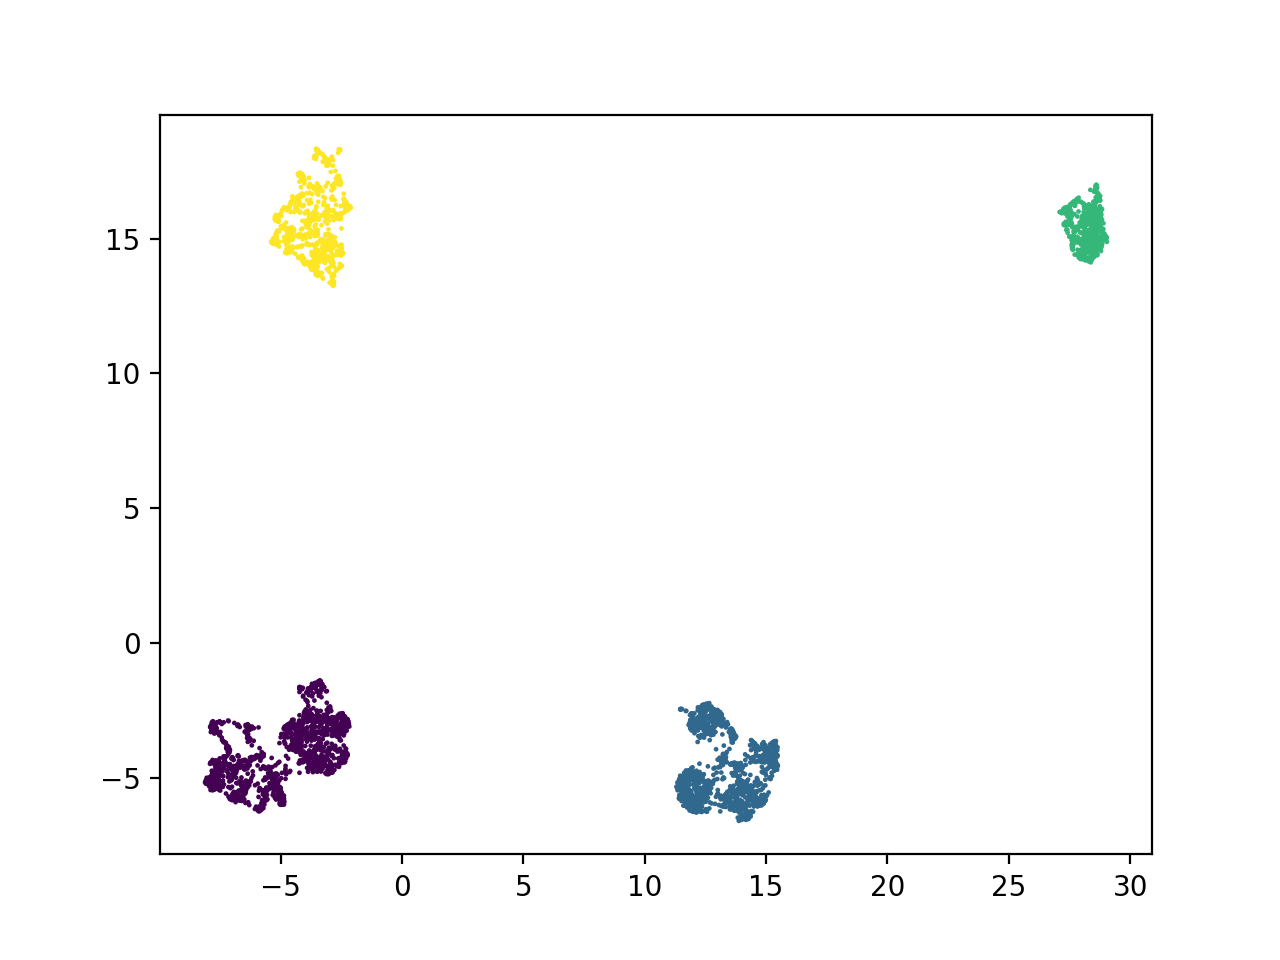

In [62]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5);

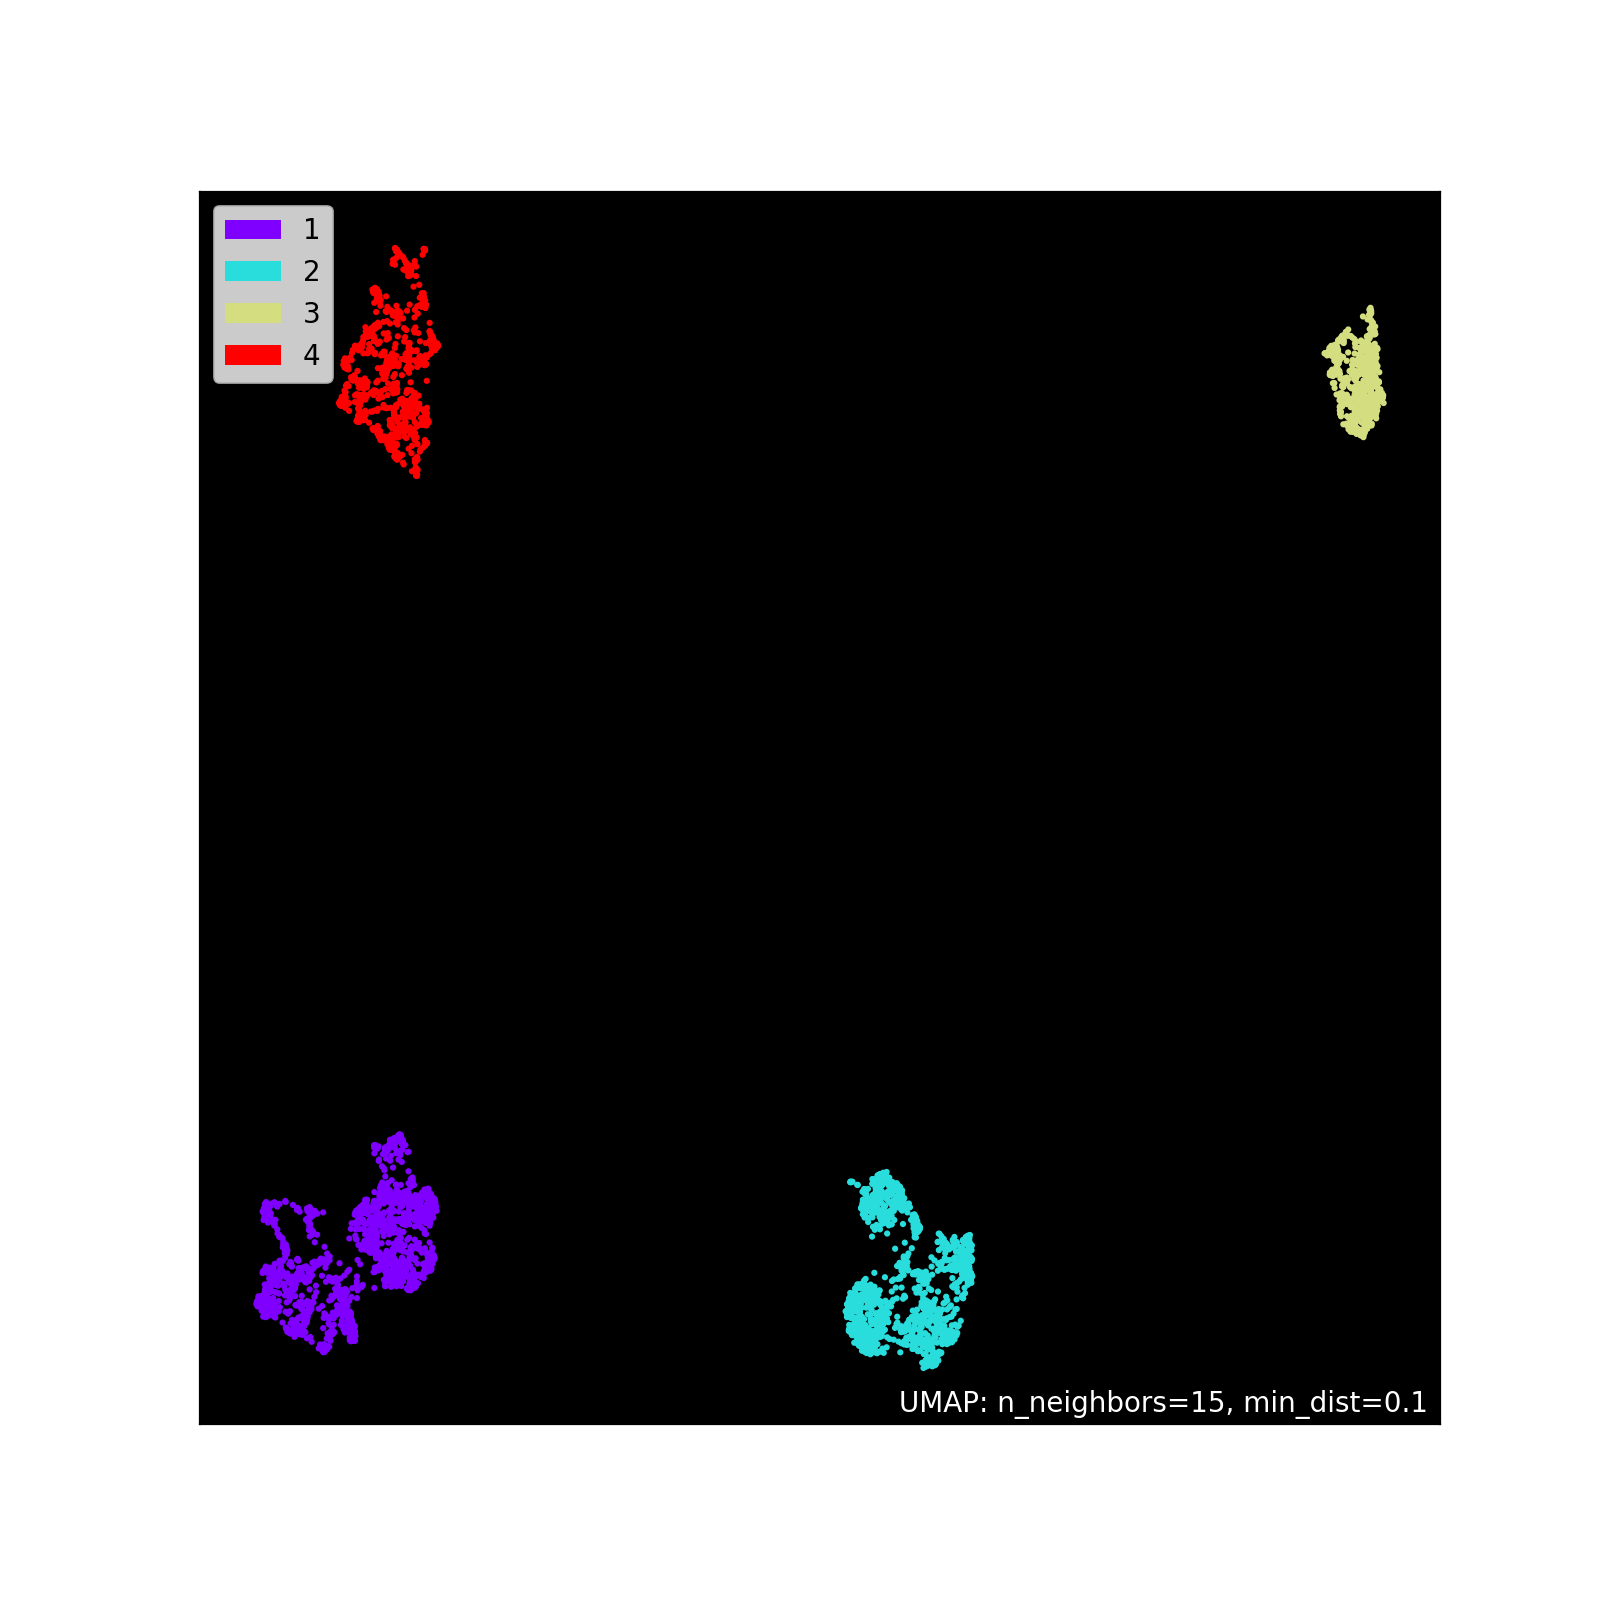

In [63]:
umap.plot.points(manifold, labels=y, theme="fire");

# 6. Evaluation

In [64]:
customer0 = df_cleaned[(df_cleaned['CustomerSegment'] == 0)]
customer1 = df_cleaned[(df_cleaned['CustomerSegment'] == 1)]
customer2 = df_cleaned[(df_cleaned['CustomerSegment'] == 2)]
customer3 = df_cleaned[(df_cleaned['CustomerSegment'] == 3)]

In [65]:
end_date = pd.Timestamp('2011-09-01')
churn0 = churn_rate(customer0, end_date)
churn1 = churn_rate(customer1, end_date)
churn2 = churn_rate(customer2, end_date)
churn3 = churn_rate(customer3, end_date)
print(churn_rate(df_cleaned, end_date))

0.31435814703848813


In [66]:
for i in range(10):
  col = 'Cluster{} sum'.format(i)
  new_col = 'Cluster{}Percentage'.format(i)
  per_customer_df[new_col] = per_customer_df[col] / per_customer_df['TotalPrice sum']

In [67]:
per_customer_df[(per_customer_df['Pred'] == 2)].describe()

,TotalPrice count,TotalPrice max,TotalPrice sum,Cluster0 sum,Cluster1 sum,Cluster2 sum,Cluster3 sum,Cluster4 sum,Cluster5 sum,Cluster6 sum,...,Cluster0Percentage,Cluster1Percentage,Cluster2Percentage,Cluster3Percentage,Cluster4Percentage,Cluster5Percentage,Cluster6Percentage,Cluster7Percentage,Cluster8Percentage,Cluster9Percentage
count,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,...,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000
mean,14.530357,1646.466770,9264.249877,671.342857,1055.407750,580.483607,2680.908464,1631.153359,136.746429,1079.424821,...,0.067854,0.110471,0.064000,0.285740,0.178979,0.016247,0.120488,0.000082,0.018688,0.137452
std,17.629840,2766.405373,21798.577796,1857.423591,2666.385195,1682.240125,6616.183349,3815.579854,613.941657,3220.150599,...,0.045370,0.053202,0.074547,0.076429,0.065330,0.023485,0.058629,0.000996,0.019717,0.067482
min,1.000000,232.690000,1632.310000,0.000000,0.000000,0.000000,0.000000,43.910000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.003830,0.000000,0.000000,0.000000,0.000000,0.008786
25%,7.000000,623.912500,3093.905000,149.477500,280.295000,89.062500,851.602500,486.615000,11.737500,326.730000,...,0.039298,0.076597,0.022035,0.239924,0.139835,0.002624,0.079607,0.000000,0.005904,0.098449
50%,10.000000,917.895000,4396.415000,266.880000,458.485000,204.600000,1244.095000,775.840000,39.350000,511.410000,...,0.059443,0.104937,0.045269,0.284500,0.175046,0.009621,0.112712,0.000000,0.013372,0.132872
75%,16.000000,1486.945000,7024.715000,517.380000,816.677500,394.965000,2143.877500,1341.420000,95.700000,875.275000,...,0.085560,0.138750,0.079896,0.327285,0.216588,0.020176,0.154106,0.000000,0.024800,0.161343
max,211.000000,30757.000000,279558.620000,22201.000000,41947.970000,23790.000000,88405.580000,57103.210000,12565.600000,56090.330000,...,0.428395,0.415438,0.689185,0.701086,0.498655,0.217939,0.420915,0.015091,0.173115,0.785711


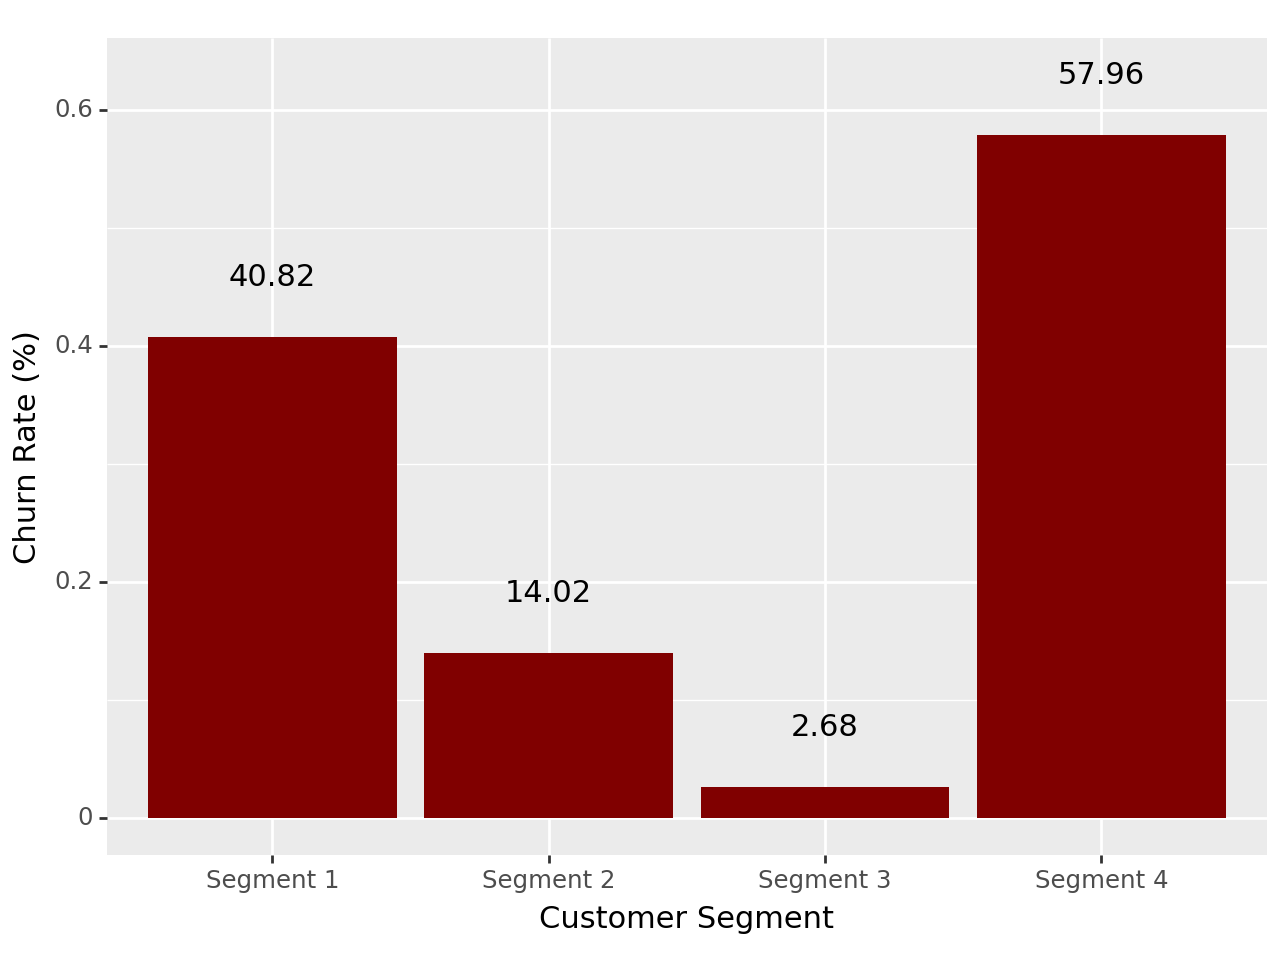

<Figure Size: (640 x 480)>

In [68]:
# @title Churn Rate by Customer Segments
churns = [churn0,churn1,churn2,churn3]
xlabels = ['Segment 1', 'Segment 2', 'Segment 3','Segment 4']
df = pd.DataFrame({'Segment': xlabels, 'ChurnRate': churns})

(
    ggplot(aes(x="Segment", weight="ChurnRate"), df) + geom_bar(fill='maroon') +
    annotate('text', x=1, y=churn0+0.05, label=round(100*churn0,2)) +
    annotate('text', x=2, y=churn1+0.05, label=round(100*churn1,2)) +
    annotate('text', x=3, y=churn2+0.05, label=round(100*churn2,2)) +
    annotate('text', x=4, y=churn3+0.05, label=round(100*churn3,2)) +
    xlab('Customer Segment') +
    ylab('Churn Rate (%)')
)

In [69]:
df['AvgBasketValue'] = per_customer_df.groupby('Pred')['TotalPrice sum'].mean()
df['AvgCancelRate'] = per_customer_df.groupby('Pred')['CancelRate'].mean()
df['AvgOrders'] = per_customer_df.groupby('Pred')['TotalPrice count'].mean()

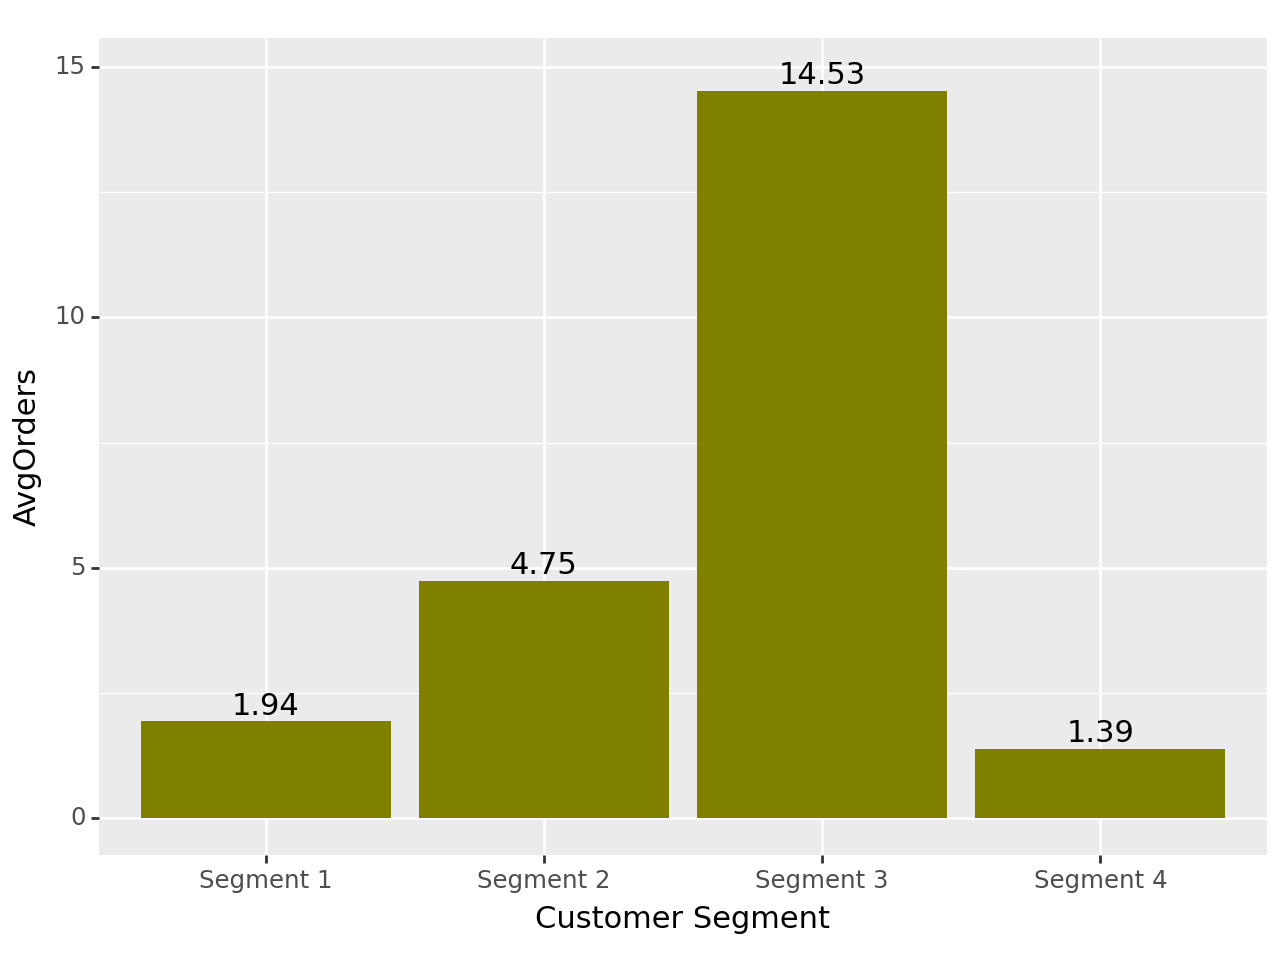

<Figure Size: (640 x 480)>

In [70]:
# @title Average Number of Orders of each Customer Segment
(
    ggplot(aes(x="Segment", weight="AvgOrders"), df) + geom_bar(fill='olive') +
    annotate('text', x=1, y=df.loc[0,'AvgOrders']+0.3, label=round(df.loc[0,'AvgOrders'],2)) +
    annotate('text', x=2, y=df.loc[1,'AvgOrders']+0.3, label=round(df.loc[1,'AvgOrders'],2)) +
    annotate('text', x=3, y=df.loc[2,'AvgOrders']+0.3, label=round(df.loc[2,'AvgOrders'],2)) +
    annotate('text', x=4, y=df.loc[3,'AvgOrders']+0.3, label=round(df.loc[3,'AvgOrders'],2)) +
    xlab('Customer Segment') +
    ylab('AvgOrders')
)

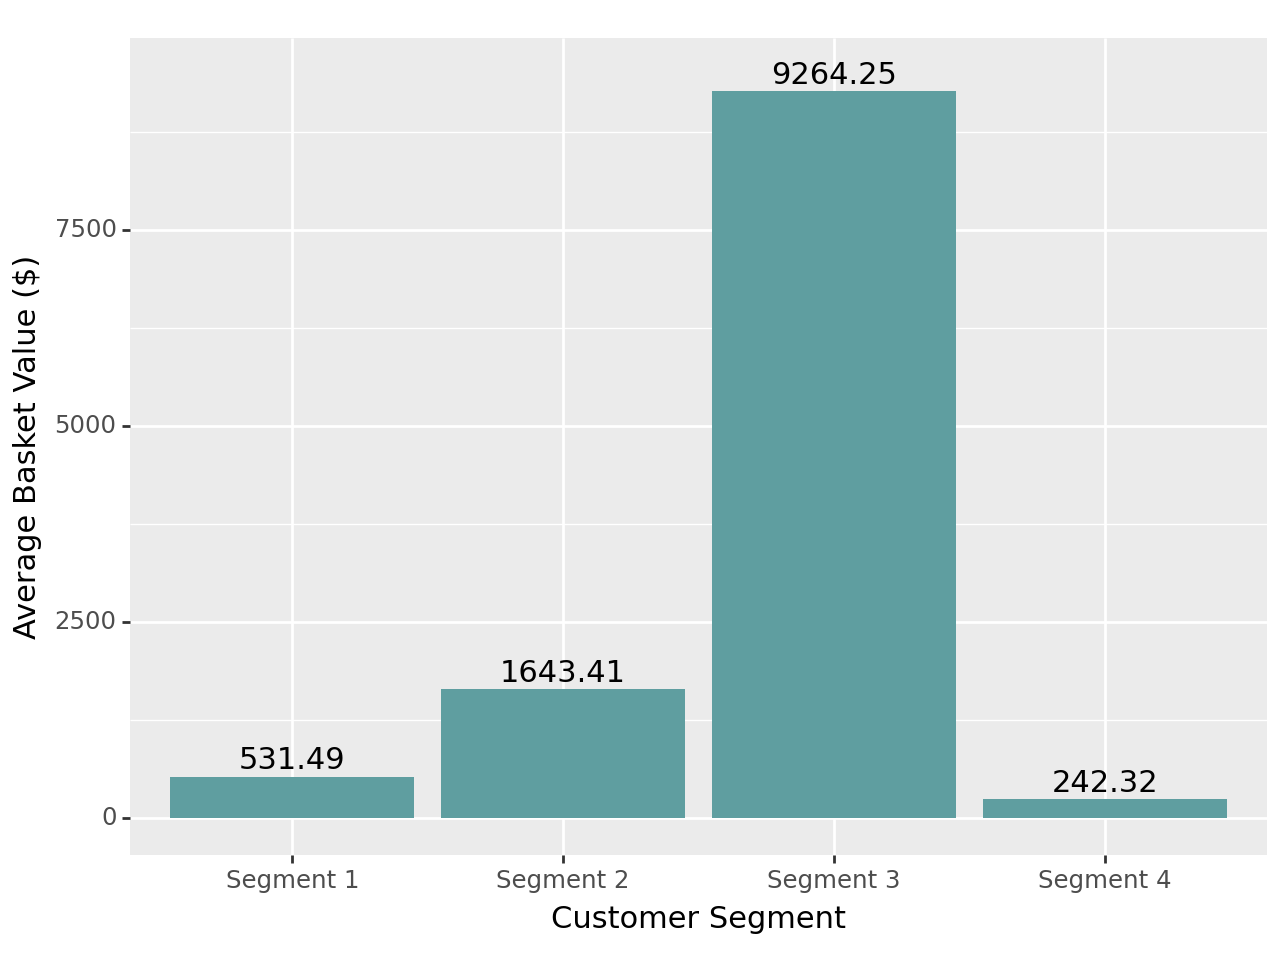

<Figure Size: (640 x 480)>

In [71]:
# @title Average Basket Value by Customer Segment
(
    ggplot(aes(x="Segment", weight="AvgBasketValue"), df) + geom_bar(fill='cadetblue') +
    annotate('text', x=1, y=df.loc[0,'AvgBasketValue']+200, label=round(df.loc[0,'AvgBasketValue'],2)) +
    annotate('text', x=2, y=df.loc[1,'AvgBasketValue']+200, label=round(df.loc[1,'AvgBasketValue'],2)) +
    annotate('text', x=3, y=df.loc[2,'AvgBasketValue']+200, label=round(df.loc[2,'AvgBasketValue'],2)) +
    annotate('text', x=4, y=df.loc[3,'AvgBasketValue']+200, label=round(df.loc[3,'AvgBasketValue'],2)) +
    xlab('Customer Segment') +
    ylab('Average Basket Value ($)')
)

In [72]:
test = pd.DataFrame(columns=list(range(4)))

for i in range(10):
  col = 'Cluster{}Percentage'.format(i)
  row = per_customer_df.groupby('Pred')[col].mean().to_frame().T
  test = pd.concat([test, row], sort=False)

test

,0,1,2,3
Cluster0Percentage,0.057193,0.068375,0.067854,0.065506
Cluster1Percentage,0.107670,0.107869,0.110471,0.104632
Cluster2Percentage,0.051951,0.062299,0.064000,0.084335
Cluster3Percentage,0.292788,0.281215,0.285740,0.324583
Cluster4Percentage,0.183701,0.180365,0.178979,0.152078
Cluster5Percentage,0.011151,0.011104,0.016247,0.013910
Cluster6Percentage,0.136274,0.132671,0.120488,0.110733
Cluster7Percentage,0.000212,0.000001,0.000082,0.000046
Cluster8Percentage,0.017007,0.016381,0.018688,0.021677
Cluster9Percentage,0.142052,0.139722,0.137452,0.122501


In [75]:
products_df[(products_df['cluster'] == 3)]

,Description,TokenizedDesc,cluster
2,DOLLY GIRL BEAKER,dolli girl beaker,3
3,I LOVE LONDON MINI BACKPACK,i love london mini backpack,3
4,I LOVE LONDON MINI RUCKSACK,i love london mini rucksack,3
5,NINE DRAWER OFFICE TIDY,nine drawer offic tidi,3
16,12 HANGING EGGS HAND PAINTED,hang egg hand paint,3
...,...,...,...
3863,ZINC HEART LATTICE TRAY OVAL,zinc heart lattic tray oval,3
3865,ZINC HERB GARDEN CONTAINER,zinc herb garden contain,3
3866,ZINC METAL HEART DECORATION,zinc metal heart decor,3
3875,ZINC WILLIE WINKIE CANDLE STICK,zinc willi winki candl stick,3


In [83]:
products_df[(products_df['cluster'] == 8)]

,Description,TokenizedDesc,cluster
30,15CM CHRISTMAS GLASS BALL 20 LIGHTS,15cm christma glass ball light,8
33,18PC WOODEN CUTLERY SET DISPOSABLE,18pc wooden cutleri set dispos,8
73,3D SHEET OF DOG STICKERS,3d sheet of dog sticker,8
96,50CM METAL STRING WITH 7 CLIPS,50cm metal string with clip,8
125,"ACRYLIC HANGING JEWEL,BLUE","acryl hang jewel , blue",8
...,...,...,...
3689,WHITE CHRISTMAS TREE 60CM,white christma tree 60cm,8
3742,WINE BOTTLE DRESSING LT.BLUE,wine bottl dress lt.blue,8
3849,YELLOW/PINK FLOWER DESIGN BIG MUG,yellow/pink flower design big mug,8
3852,YULETIDE IMAGES S/6 PAPER BOXES,yuletid imag s/6 paper box,8
